# NDVI Climatology

* **Products used:** 
[ndvi_climatology_ls](https://explorer.digitalearth.africa/products/ndvi_climatology_ls)

## Background

Climatology refers to conditions averaged over a long period of time, typically greater than 30 years. The Digital Earth Africa NDVI Climatology product represents the long-term average baseline condition of vegetation for every Landsat pixel over the African continent. Both mean and standard deviation NDVI climatologies are available for each calendar month based on calculation over the period 1984-2020. NDVI climatologies may be used for many applications including identifying extremeties (anomalies) in vegetation condition, identifying both long and short-term changes in vegetation condition, and as an input into machine learning processes for land use classification.

Further details on the calculation of the product are available in the [NDVI Climatology technical specifications](https://docs.digitalearthafrica.org/en/latest/data_specs/NDVI_Climatology_specs.html) documentation.

**Important details:**

* Datacube product name: `ndvi_climatology_ls`
* Measurements
    * `mean_<month>`: These measurements show the mean NDVI calculated from all available NDVI data from 1984-2020 for the given month.
    * `stddev_<month>`: These measurements show the standard deviation of NDVI values of all available NDVI data from 1984-2020 for the given month.
    * `count_<month>`: These measaurements show the number of clear observations that go into creating the mean and standard deviation measurements. Importantly, caution should be used when applying this product to regions where the clear observation count is less than approximately 20-30. This can often be the case over equatorial Africa due to frequent cloud cover and inconsistent coverage of Landsat-5. 
* Status: Provisional
* Date-range: The time dimension represents calendar months aggregated across the period 1984-2020.
* Spatial resolution: 30m

## Description

In this notebook we will load the NDVI Climatology product using `dc.load()` to return mean, standard deviation, and clear observation count for each calendar month. A final section explores an example analysis using the product.

Topics covered include:
1. Inspecting the NDVI Climatology product and measurements available in the datacube.
2. Using the native `dc.load()` function to load in NDVI Climatology.
3. Inspect perennial and annual vegtation using NDVI mean and standard deviation.
4. Exaple analysis: analyse and plot the climatological (long-term average) phenology of croplands

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [6]:
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk

from deafrica_tools.plotting import display_map

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Connect to the datacube

In [7]:
dc = datacube.Datacube(app='NDVI_clim')

## Available measurements

### List measurements

The table printed below shows the measurements available in the NDVI Climatology product. The mean NDVI, standard deviation of NDVI, and clear obervations count can be loaded for each calendar month.

In [8]:
product_name = 'ndvi_climatology_ls'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,name,dtype,units,nodata,aliases
measurement,,,,,
mean_jan,mean_jan,float32,1,NaN,"[MEAN_JAN, mean_january]"
mean_feb,mean_feb,float32,1,NaN,"[MEAN_FEB, mean_february]"
mean_mar,mean_mar,float32,1,NaN,"[MEAN_MAR, mean_march]"
mean_apr,mean_apr,float32,1,NaN,"[MEAN_APR, mean_april]"
mean_may,mean_may,float32,1,NaN,[MEAN_MAY]
mean_jun,mean_jun,float32,1,NaN,"[MEAN_JUN, mean_june]"
mean_jul,mean_jul,float32,1,NaN,"[MEAN_JUL, mean_july]"
mean_aug,mean_aug,float32,1,NaN,"[MEAN_AUG, mean_august]"
mean_sep,mean_sep,float32,1,NaN,"[MEAN_SEP, mean_september]"


### Analysis parameters

This section defines the analysis parameters, including:

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `resolution`: the pixel resolution to use for loading the `ndvi_climatology_ls`. The native resolution of the product is 30 metres i.e. `(-30,30)` as the product is Landsat derived.

The default location is an cropping region in Western Cape, South Africa where an irrigation scheme along a river is surrounded by rain-fed cropping.

In [9]:
lat, lon = -18.7557, 46.4644 # Madagascar

buffer = 7.0

resolution=(- 500, 500)

#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [10]:
display_map(lon_range, lat_range)

## Load data

Below we use the `dc.load` function to load all the measurements over the region specified above. 


In [11]:
# load data
ndvi_clim = dc.load(
    product="ndvi_climatology_ls",
    resolution=resolution,
    x=lon_range,
    y=lat_range,
    progress_cbk=with_ui_cbk(),
)

print(ndvi_clim)

<xarray.Dataset>
Dimensions:      (time: 1, y: 3380, x: 2703)
Coordinates:
  * time         (time) datetime64[ns] 2002-07-02T11:59:59.999999
  * y            (y) float64 -1.489e+06 -1.49e+06 ... -3.178e+06 -3.179e+06
  * x            (x) float64 3.808e+06 3.808e+06 ... 5.158e+06 5.159e+06
    spatial_ref  int32 6933
Data variables: (12/36)
    mean_jan     (time, y, x) float32 0.8302 0.8562 0.8154 ... nan nan nan
    mean_feb     (time, y, x) float32 0.8371 0.8545 0.8556 ... nan nan nan
    mean_mar     (time, y, x) float32 0.829 0.8299 0.8382 0.8448 ... nan nan nan
    mean_apr     (time, y, x) float32 0.848 0.8617 0.8652 0.8533 ... nan nan nan
    mean_may     (time, y, x) float32 0.8125 0.8253 0.8156 ... nan nan nan
    mean_jun     (time, y, x) float32 0.7422 0.7481 0.7319 ... nan nan nan
    ...           ...
    count_jul    (time, y, x) int16 32 31 32 33 33 ... -999 -999 -999 -999 -999
    count_aug    (time, y, x) int16 27 27 29 27 26 ... -999 -999 -999 -999 -999
    count_sep 

## Plotting NDVI Climatology


### Store measurements

As this dataset has a lot of measurements, it is easier to store them in a list and access them as we need when plotting etc., rather than typing out each measurement

In [12]:
measurements = [i for i in ndvi_clim.data_vars]
mean_bands = measurements[0:12]
std_bands = measurements[12:24]
count_bands = measurements[24:36]

### Add a time dimension to the climatologies

Adding a time dimension to the dataset by concatenating the months together allows us to quickly make plots or calculate ket statistics without looping through separate datasets.

**Important note:**
The date '2002' is meaningless, its simply the middle point between 1984 and 2020 - the range over which the climatologies were calculated.

In [13]:
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

arrs_mean = []
arrs_std = []
arrs_count = []
for m,s,c,i in zip(mean_bands, std_bands, count_bands, months):
    #index out the different types of measurements
    xx_mean=ndvi_clim[m]
    xx_std=ndvi_clim[s]
    xx_count=ndvi_clim[c]
    
    #add a time dimension corresponding to the right month
    time = pd.date_range(np.datetime64('2002-'+i+'-15'), periods=1)
    xx_mean['time'] = time
    xx_std['time'] = time
    xx_count['time'] = time
    
    #append to lists
    arrs_count.append(xx_count)
    arrs_mean.append(xx_mean)
    arrs_std.append(xx_std)

#concatenate into 3D data array along time dimension
ndvi_mean = xr.concat(arrs_mean, dim='time').rename('NDVI_Climatology_Mean')
ndvi_std = xr.concat(arrs_std, dim='time').rename('NDVI_Climatology_Std')
ndvi_count = xr.concat(arrs_count, dim='time').rename('NDVI_Climatology_Count')

### Facet plot the mean NDVI climatology 

The plots below show that, on average, the irrigated fields around the river, and the riparian vegetetation are more persistently green throughout the year, while the rainfed cropping regions are green through the winter months of June, July, August, and September.

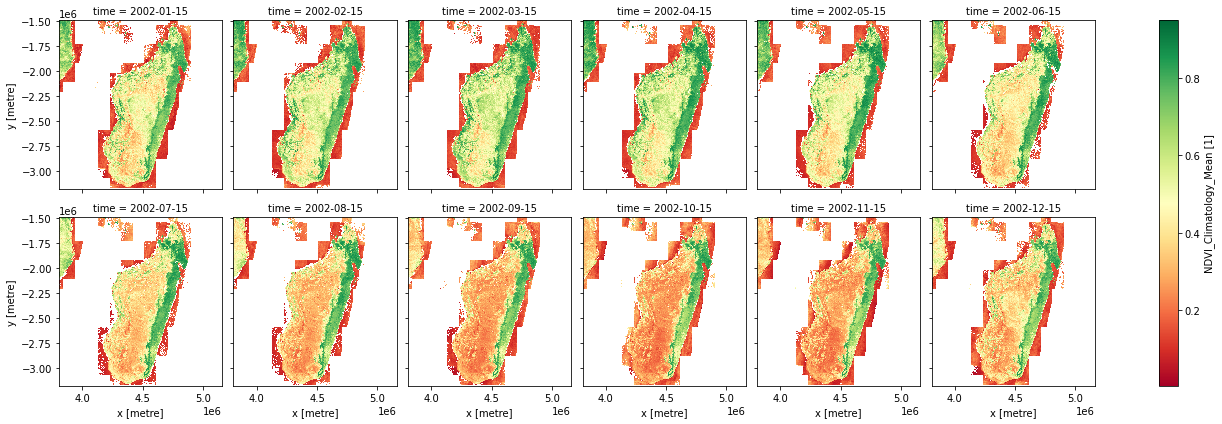

In [14]:
ndvi_mean.plot.imshow(col='time', col_wrap=6, cmap="RdYlGn");

### Facet plot the standard deviation NDVI climatology 

Note the irrigated regions tend to show greater variability than the other pixels. By enabling distinction between classes of agricultural land and other vegetation, this might be a good input to land use classification methods such as thresholding or more complex machine learning approaches.

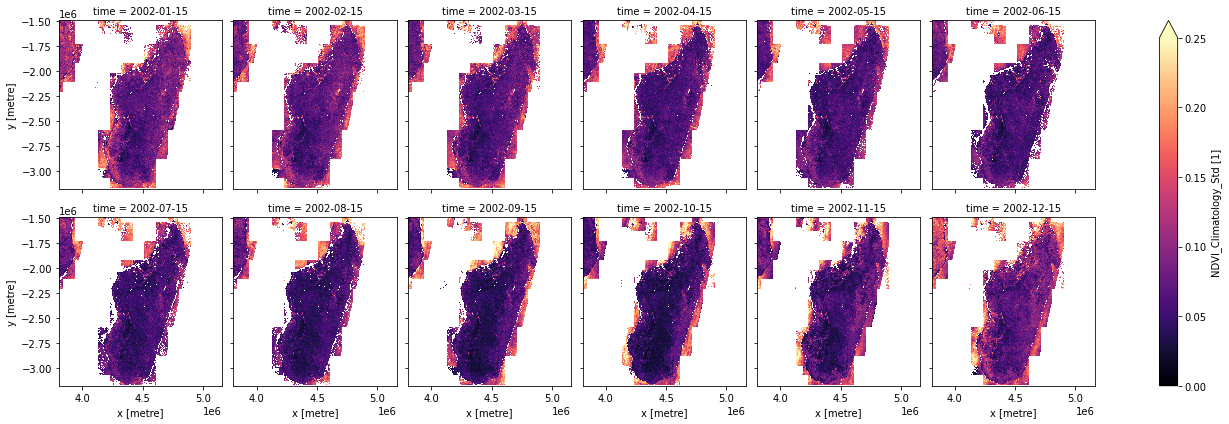

In [15]:
ndvi_std.plot.imshow(col='time', col_wrap=6, cmap="magma", vmax=0.25);

### Facet plot the clear count 

We can use these plots to understand how many observations are going into the climatology calculations. Below (in the default example) we can that in the drier months there are ~25-35 observations (over the 37 year period of the climatology), while in the winter months there are ~20. In this case, because the observation count is relatvely low for the winter months, we should be careful when using the climatology in those months.  In this specific example the mean and standard deviation measurements plotted above look okay, probably because the region is at a higher latitude and therefore not so affected by cloud. If this region was in the tropics then the dataset may be of a poorer quality. 

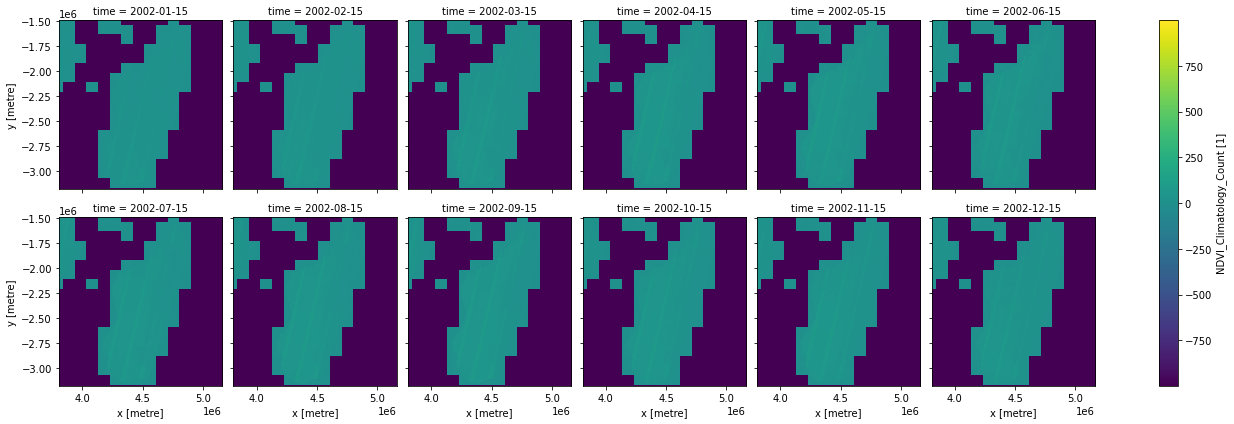

In [16]:
ndvi_count.plot.imshow(col='time', col_wrap=6, cmap="viridis");

## Example Analysis: Cropland Climatological Phenology

We can use the NDVI climatology product to generate long-term average phenological patterns for specific regions, landscapes, or vegetation types. Limiting our analysis of the area above to a crop mask enables us to investigate the long-term average phenology of cropland.

In [17]:
#import deafrica's phenology function
from deafrica_tools.temporal import xr_phenology

Load the cropmask dataset for the region

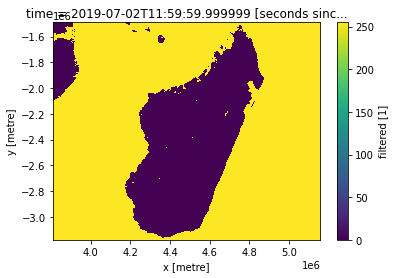

In [51]:
cm = dc.load(product="crop_mask",
             measurements='filtered',
            resampling='nearest', 
            like=ndvi_clim.geobox).filtered.squeeze()

cm.plot.imshow()

Mask the datasets with the crop mask

In [52]:
ndvi_mean_crop = ndvi_mean.where(cm)
ndvi_std_crop = ndvi_std.where(cm)

### Plot phenology curve

Below we summarise the datasets spatially by taking the mean across the `x` and `y` dimensions, this will leave us with the average trend through `time` for the region we've loaded.

When we plot the phenology curve below, we will add +- 1 standard deviation around the mean curve to indicate, on average, how much the trends vary around the long-term mean.

From the phenology plot, we can conclude that crop growth generally commences around May and continues until harvest around October.

In [53]:
ndvi_mean_crop_line = ndvi_mean_crop.mean(['x','y'])
ndvi_std_crop_line = ndvi_std_crop.mean(['x','y'])

#upper and lower boundaries
ndvi_std_upper =  ndvi_mean_crop_line+ndvi_std_crop_line
ndvi_std_lower = ndvi_mean_crop_line-ndvi_std_crop_line

Plot the mean phenology curve, with +-1 standard deviation envelope

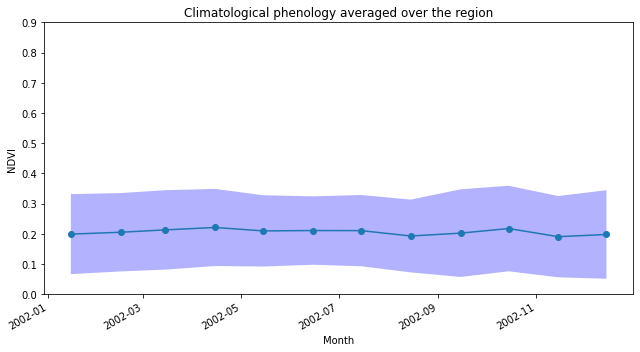

In [54]:
ndvi_mean_crop_line.plot(figsize=(9,5), marker='o')
plt.fill_between(
    ndvi_mean_crop_line.time.values,
    ndvi_std_upper.values,
    ndvi_std_lower.values,
    facecolor="blue",
    alpha=0.3,
)
plt.ylim(0,0.9)
plt.title('Climatological phenology averaged over the region')
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.tight_layout()

### Per pixel climatological phenology

Having plotted in the spatially averaged climatological phenology, we can now use the DE Africa function `xr_phenology` to calculate the typical phenology of every pixel in the dataset.

This function computes key phenological statistics expressed as the day-of-the-year (DOY) at: 
* Start of Season (SOS),
* Peak of Season (POS),
* End of Season (EOS).

It also gives NDVI values (v) for the times above (e.g. vSOS for the NDVI value at the start of season), and other variables including:
* Trough: minimum NDVI value of season,
* LOS: Length of season,
* AOS: Amplitude of season (difference between the base and maximum NDVI values),
* ROG: Rate of greening,
* ROS: Rate of senescence.

**Important note:**
Remember that this product is monthly (not daily) so the DOY is simply the middle of the month when the NDVI peaks, for example (we set the time dimension to be the 15th of each month in the "adding time dimension" section above).

In [55]:
#calculate per-pixel phenology
phen = xr_phenology(ndvi_mean_crop, method_eos='median', method_sos='median', verbose=False)

#mask again with crop-mask
phen = phen.where(cm)

print(phen)

<xarray.Dataset>
Dimensions:      (y: 3380, x: 2703)
Coordinates:
  * y            (y) float64 -1.489e+06 -1.49e+06 ... -3.178e+06 -3.179e+06
  * x            (x) float64 3.808e+06 3.808e+06 ... 5.158e+06 5.159e+06
    spatial_ref  int32 6933
    time         datetime64[ns] 2019-07-02T11:59:59.999999
Data variables:
    SOS          (y, x) float64 nan nan nan nan nan ... 15.0 15.0 15.0 15.0 15.0
    POS          (y, x) float64 nan nan nan nan nan ... 15.0 15.0 15.0 15.0 15.0
    EOS          (y, x) float64 nan nan nan nan nan ... 46.0 46.0 46.0 46.0 46.0
    Trough       (y, x) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vSOS         (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    vPOS         (y, x) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vEOS         (y, x) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    LOS          (y, x) float64 nan nan nan nan nan ... 31.0 31.0 31.0 31.0 31.0
    AOS          (y, x) float32 nan na

### Plot per pixel phenology

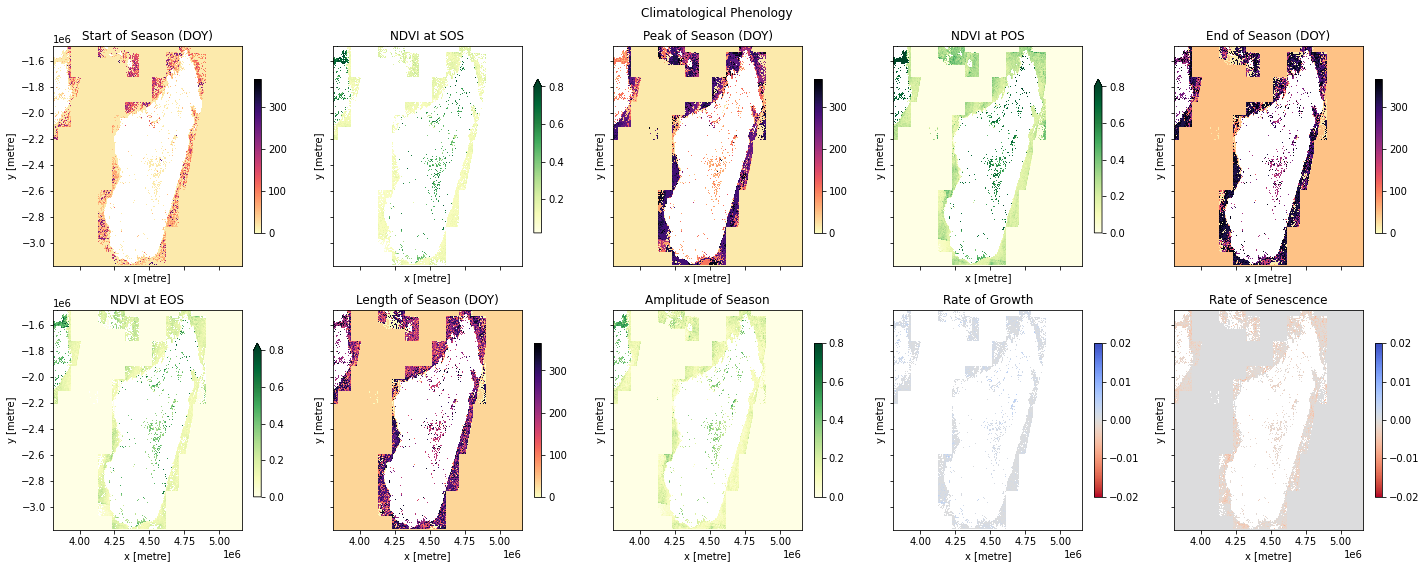

In [56]:
# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(20, 8),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# start of season
phen.SOS.plot.imshow(ax=ax[0, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')

phen.vSOS.plot.imshow(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title('NDVI at SOS')

# peak of season
phen.POS.plot.imshow(ax=ax[0, 2],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 2].set_title('Peak of Season (DOY)')
phen.vPOS.plot.imshow(ax=ax[0, 3],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title('NDVI at POS')

# end of season
phen.EOS.plot.imshow(ax=ax[0, 4],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 4].set_title('End of Season (DOY)')
phen.vEOS.plot.imshow(ax=ax[1, 0],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('NDVI at EOS')

# Length of Season
phen.LOS.plot.imshow(ax=ax[1, 1],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot.imshow(ax=ax[1, 2],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title('Amplitude of Season')

# rate of growth
phen.ROG.plot.imshow(ax=ax[1, 3],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 3].set_title('Rate of Growth')

# rate of Sensescence
phen.ROS.plot.imshow(ax=ax[1, 4],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 4].set_title('Rate of Senescence')
plt.suptitle('Climatological Phenology')
plt.tight_layout();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-02-22'